# URP identification using C-BLSTM

In this notebook, we implemmented the <b>Convolution Bidirectional Long Short-Term Memory</b> (<i>C-BLSTM</i>) using keras and tensorflow libraries. In here, we plot some graphics like the model training accuracy and a word cloud with the most words used in URP sentences. For this model, the f1-score, recall and precision has been measured and apresented.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from keras.preprocessing import text, sequence
from nltk.tokenize import word_tokenize
from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, AveragePooling1D
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional, TimeDistributed, CuDNNLSTM, CuDNNGRU
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, SeparableConv1D, Conv1D

Using TensorFlow backend.


### Import Database

In [2]:
mypath = 'No Stem Data'

base = pd.DataFrame()
for file in listdir(mypath):
    print(file)
    new_entries_base = pd.read_excel(mypath+'/'+file)
    base = base.append(new_entries_base,ignore_index=True)


naoPru_Clean.xlsx
Pru_Clean.xlsx
twitter_Clean.xlsx


In [3]:
x = base['Postagens'].values
classes = ["PRU", "NPRU"]
y = base[classes].values
new_x = pd.DataFrame()
lista = []
for c in x:
    lista.append(word_tokenize(str(c)))
new_x = lista

### Padding Sentences

In [4]:
max_features = 15000
maxlen = 45
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(new_x))
new_x = tokenizer.texts_to_sequences(new_x)
X_comp = sequence.pad_sequences(new_x, maxlen=maxlen)
X_comp[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  825,   10,    2,  172,   76,    8,  825,
       1660])

### Dividing Database

In [5]:
xTrain, xTest, yTrain, yTest = train_test_split(X_comp, y, test_size=0.2, random_state=42)
print(len(yTrain))
print(len(yTest))

3093
774


## C-BLSTM Model

### Creation

In [8]:
embedding_size = 128
kernel_size = 5
filters = 350
pool_size = 2
lstm_output_size = 350

cblstm = Sequential()
cblstm.add(Embedding(max_features, embedding_size, input_length=maxlen))
cblstm.add(SeparableConv1D(filters,
              kernel_size,
              padding='same',
              activation='relu',
              strides=1))
cblstm.add(MaxPooling1D(pool_size=pool_size))
cblstm.add(Dropout(0.15))
cblstm.add(CuDNNLSTM(lstm_output_size))
cblstm.add(Dropout(0.1))
cblstm.add(Dense(25,activation='sigmoid'))
cblstm.add(Dense(2,activation='sigmoid'))

cblstm.summary()
cblstm.compile(loss='mse', 
			  optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 45, 128)           1920000   
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 45, 350)           45790     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 22, 350)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 350)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 350)               982800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                8775      
__________

### Train and Evaluate

In [9]:
history= cblstm.fit(xTrain, yTrain, batch_size=20, epochs=10, validation_split=0.15, verbose=1)
y_cblstm = cblstm.predict(xTest)
print(classification_report(yTest, y_cblstm.round()))

Train on 2629 samples, validate on 464 samples
Epoch 1/10
2629/2629 [==============================] - 5s 2ms/step - loss: 0.2043 - acc: 0.6615 - val_loss: 0.1358 - val_acc: 0.8276
Epoch 2/10
2629/2629 [==============================] - 4s 2ms/step - loss: 0.0842 - acc: 0.8950 - val_loss: 0.1116 - val_acc: 0.8556
Epoch 3/10
2629/2629 [==============================] - 4s 2ms/step - loss: 0.0337 - acc: 0.9642 - val_loss: 0.1051 - val_acc: 0.8578
Epoch 4/10
2629/2629 [==============================] - 4s 2ms/step - loss: 0.0170 - acc: 0.9825 - val_loss: 0.1096 - val_acc: 0.8599
Epoch 5/10
2629/2629 [==============================] - 4s 2ms/step - loss: 0.0105 - acc: 0.9901 - val_loss: 0.1144 - val_acc: 0.8664
Epoch 6/10
2629/2629 [==============================] - 4s 2ms/step - loss: 0.0076 - acc: 0.9924 - val_loss: 0.1185 - val_acc: 0.8599
Epoch 7/10
2629/2629 [==============================] - 5s 2ms/step - loss: 0.0051 - acc: 0.9954 - val_loss: 0.1079 - val_acc: 0.8707
Epoch 8/10
2629

In [31]:
cblstm.evaluate(xTest, yTest)

774/774 [==============================] - 0s 595us/step


[0.10598393021878191, 0.8746770024299622]

In [10]:
y_pred = cblstm.predict_classes(xTest)
y_pru = []
for i in range(len(yTest)):
    y_pru.append(yTest[i][1])
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_pru, y_pred)
print(matrix)

[[367  42]
 [ 55 310]]


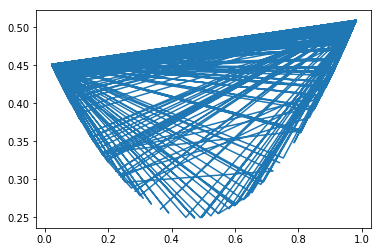

In [12]:
y_predcblsm=[]
for i in range(len(y_cblstm)):
    y_predcblsm.append(y_cblstm[i][1])
from sklearn.metrics import brier_score_loss
from matplotlib import pyplot
losses = [brier_score_loss(y_pru, [y for x in range(len(y_pru))]) for y in y_predcblsm]
pyplot.plot(y_predcblsm, losses)
pyplot.show()

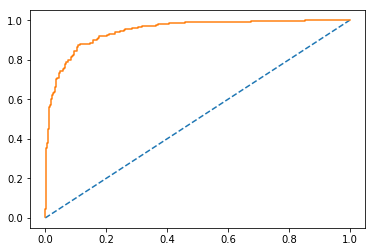

In [13]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_pru, y_predcblsm)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr)
# show the plot
pyplot.show()

In [14]:
from sklearn import metrics
metrics.auc(fpr, tpr)

0.9451920822587668

In [15]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.25502884

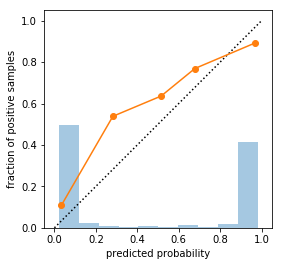

In [18]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        if normalize:
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve
plot_calibration_curve(y_pru, y_predcblsm)

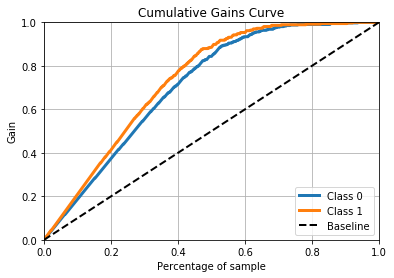

In [19]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_pru, y_cblstm)
plt.show()

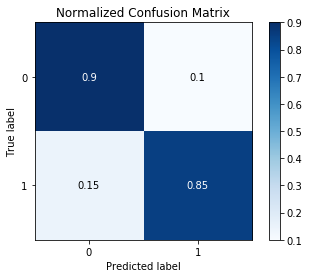

In [35]:
skplt.metrics.plot_confusion_matrix(y_pru, y_pred, normalize=True)

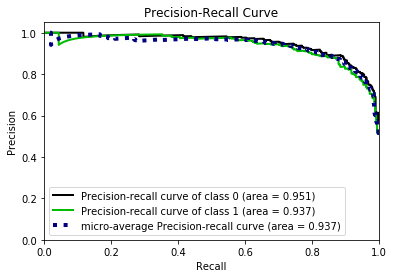

In [24]:
skplt.metrics.plot_precision_recall_curve(y_pru, y_cblstm)

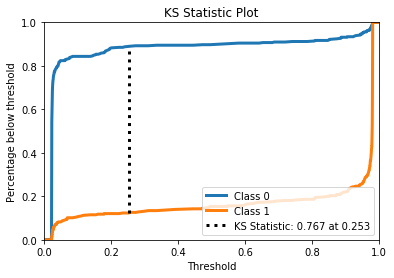

In [25]:
skplt.metrics.plot_ks_statistic(y_pru, y_cblstm)

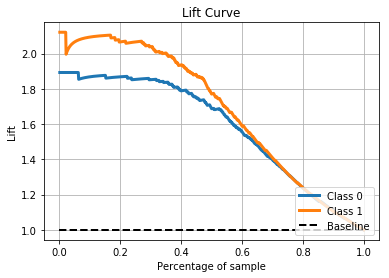

In [26]:
skplt.metrics.plot_lift_curve(y_pru, y_cblstm)

Text(0.5,1,'2-class Precision-Recall curve: AP=0.82')

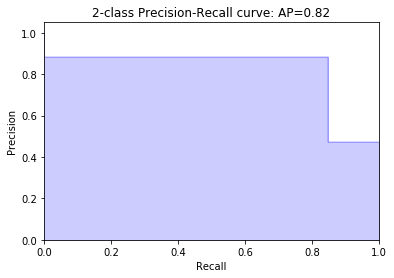

In [30]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_pru, y_pred)

from sklearn.metrics import precision_recall_curve
from sklearn.utils.fixes import signature
precision, recall, _ = precision_recall_curve(y_pru, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

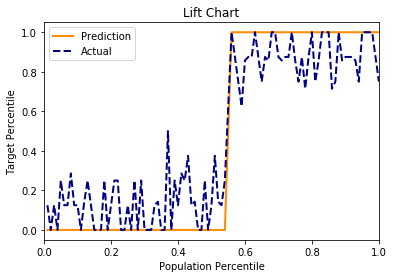

In [20]:
def plotLiftChart(actual, predicted):
    df_dict = {'actual': list (actual), 'pred': list(predicted)}
    df = pd.DataFrame(df_dict)
    pred_ranks = pd.qcut(df['pred'].rank(method='first'), 100, labels=False)
    actual_ranks = pd.qcut(df['actual'].rank(method='first'), 100, labels=False)
    pred_percentiles = df.groupby(pred_ranks).mean()
    actual_percentiles = df.groupby(actual_ranks).mean()
    plt.title('Lift Chart')
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['pred']),
             color='darkorange', lw=2, label='Prediction')
    plt.plot(np.arange(.01, 1.01, .01), np.array(pred_percentiles['actual']),
             color='navy', lw=2, linestyle='--', label='Actual')
    plt.ylabel('Target Percentile')
    plt.xlabel('Population Percentile')
    plt.xlim([0.0, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="best")
plotLiftChart(y_pru,y_pred)

In [124]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

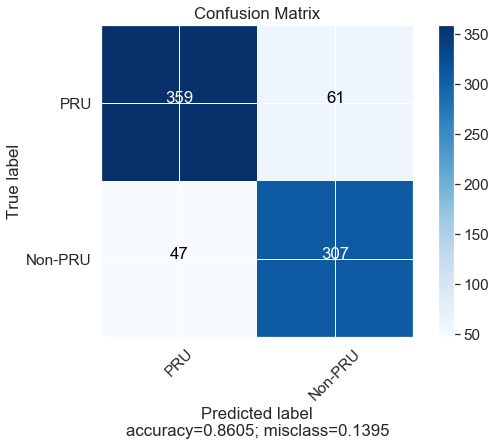

In [127]:
plot_confusion_matrix(cm           = matrix, 
                      normalize    = False,
                      target_names = ['PRU', 'Non-PRU'],
                      title        = "Confusion Matrix")

### Train and Test View

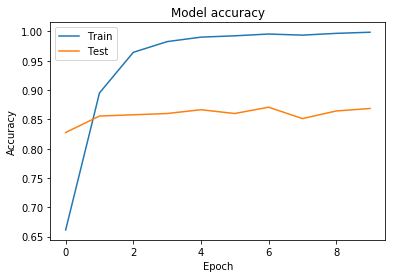

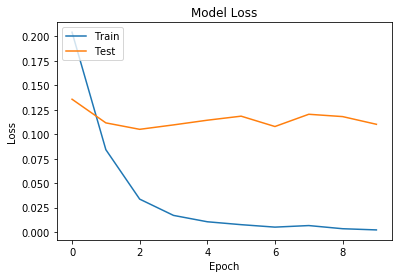

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
cblstm.save_weights('CBLSTM.h5')
model_json = cblstm.to_json()
with open("CBLSTM.json", "w") as json_file:
    json_file.write(model_json)